In [1]:
import os
import sys
import pathlib
import getpass

## Environment Setup

This section checks the runtime environment to see if the notebook is running inside a Google Colab instance. If it is, then it installs the `makassar-ml` package from the GitHub repo and mounts the user's Google Drive folder to the workspace.

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

except:
    IN_COLAB = False
    print('NOT IN COLAB')

IN COLAB


In [3]:
# Install package from GitHub if in Google Drive.
if IN_COLAB:
    config_path = pathlib.Path('./config.json')
    if config_path.exists():
        import json
        with open(config_path, 'r') as f:
            j = json.load(f)
        os.environ['GITHUB_TOKEN'] = j['GITHUB_TOKEN']

    else:

        # Request GitHub access token.
        if os.getenv('GITHUB_TOKEN',None) is None:
            os.environ['GITHUB_TOKEN'] = getpass.getpass('GitHub Token: ')
        else:
            print('Using cached GitHub Token')
        
        import json
        with open(config_path, 'w+') as f:
            json.dump(
                {'GITHUB_TOKEN': os.environ['GITHUB_TOKEN']}, 
                f,
            )

    # Clone or update repo.
    repo = "makassar-ml"
    repo_url = f"https://{os.environ['GITHUB_TOKEN']}@github.com/news-vt/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

Already up to date.
Processing ./makassar-ml
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for makassar-ml: filename=makassar_ml-0.1.0-py3-none-any.whl size=6953 sha256=c687bc8742f629286ff2b78630335ba7ef7f2cf4349f9b69fb84f40a35e32214
  Stored in directory: /root/.cache/pip/wheels/74/23/8c/5a926f2dd1be9f44af1bf2ca82c4066c5a37ead034a2c97554
Successfully built makassar-ml
  Attempting uninstall: makassar-ml
    Found existing installation: makassar-ml 0.1.0
    Uninstalling makassar-ml-0.1.0:
      Success

In [4]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [5]:
# Model save location in Google Drive.
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Set dataset and model checkpoint root directories.
if IN_COLAB:
    dataset_root = pathlib.Path(f'/content/gdrive/My Drive/ml/datasets')
    checkpoint_root = pathlib.Path(f'/content/gdrive/My Drive/ml/makassar-ml/checkpoints')
else:
    dataset_root = pathlib.Path('../datasets/')
    checkpoint_root = pathlib.Path('../model_checkpoints/')

## Model Definitions

In [7]:
from __future__ import annotations
import makassar_ml as ml
import pytorch_lightning as pl
import torch
from typing import Optional

In [8]:
class BeijingPM25LightningDataModule(pl.LightningDataModule):
    def __init__(self, 
        root: str, 
        feature_cols: list[int], 
        target_cols: list[int], 
        history: int, 
        horizon: int, 
        split: float,
        batch_size: int,
        ):
        self.root = root
        self.feature_cols = feature_cols
        self.target_cols = target_cols
        self.history = history
        self.horizon = horizon
        self.split = split
        self.batch_size = batch_size

    def prepare_data(self):
        # Download the dataset.
        ml.datasets.BeijingPM25Dataset(
            root=self.root,
            download=True,
            )

    def setup(self, stage: Optional[str] = None):

        # Create train/val datasets for dataloaders.
        if stage == 'fit' or stage is None:
            dataset_train_full = ml.datasets.BeijingPM25Dataset(
                root=self.root,
                download=False,
                train=True,
                split=self.split,
                )
            train_n = len(dataset_train_full)
            train_val_cutoff = train_n - round(train_n*.25) # 75% train, 25% val

            self.dataset_train = torch.utils.data.Subset(dataset_train_full, list(range(0, train_val_cutoff)))
            self.dataset_val = torch.utils.data.Subset(dataset_train_full, list(range(train_val_cutoff, train_n)))

            self.dataset_train_wrap = ml.datasets.TimeseriesForecastDatasetWrapper(
                dataset=self.dataset_train,
                feature_cols=self.feature_cols,
                target_cols=self.target_cols,
                history=self.history,
                horizon=self.horizon,
                )
            self.dataset_val_wrap = ml.datasets.TimeseriesForecastDatasetWrapper(
                dataset=self.dataset_val,
                feature_cols=self.feature_cols,
                target_cols=self.target_cols,
                history=self.history,
                horizon=self.horizon,
                )

        # Create test dataset for dataloaders.
        if stage == 'test' or stage is None:
            self.dataset_test = ml.datasets.BeijingPM25Dataset(
                root=self.root,
                download=False,
                train=False,
                split=self.split,
                )
            self.dataset_test_wrap = ml.datasets.TimeseriesForecastDatasetWrapper(
                dataset=self.dataset_test,
                feature_cols=self.feature_cols,
                target_cols=self.target_cols,
                history=self.history,
                horizon=self.horizon,
                )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=self.dataset_train_wrap,
            batch_size=self.batch_size,
            )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=self.dataset_val_wrap,
            batch_size=self.batch_size,
            )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=self.dataset_test_wrap,
            batch_size=self.batch_size,
            )

In [9]:
# Note that for Transformer decoder target mask,
# the `length` parameter is the desired length of
# the target sequence.
# See docs: https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer.forward
def create_attn_mask(length: int):
    """Generate mask used for attention mechanisms.

    Masks are a lower-triangular matrix of zeros
    with the other entries taking value "-inf".

    Args:
        length (int): Length of square-matrix dimension.

    Examples:
        >>> create_attn_mask(3)
        tensor([[0., -inf, -inf],
                [0., 0., -inf],
                [0., 0., 0.]])
    """
    # Get lower-triangular matrix of ones.
    mask = torch.tril(torch.ones(length, length))

    # Replace 0 -> "-inf" and 1 -> 0.0
    mask = (
        mask
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask

In [10]:
class TimeseriesTransformer(torch.nn.Module):

    def __init__(self,
        n_input_features: int,
        n_output_features: int,
        d_time_embed: int,
        d_model: int = 512,
        dropout: float = 0.1,
        batch_first: bool = False,
        n_encoder_layers: int = 4,
        n_decoder_layers: int = 4,
        n_encoder_heads: int = 8,
        n_decoder_heads: int = 8,
        ):
        super().__init__()

        self.batch_first = batch_first

        # Time embedding.
        self.time_projection = ml.time2vec.Time2Vec(input_dim=n_input_features, embed_dim=d_time_embed)

        # Linear transformation from input-feature space into arbitrary n-dimension space.
        # This is similar to a word embedding used in NLP tasks.
        self.encoder_projection = torch.nn.Linear(in_features=d_time_embed, out_features=d_model)
        self.decoder_projection = torch.nn.Linear(in_features=n_output_features, out_features=d_model)

        # Transformer encoder/decoder layers.
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_encoder_heads, # Number of multihead-attention models.
            dropout=dropout,
            dim_feedforward=4*d_model,
            batch_first=batch_first,
        )
        decoder_layer = torch.nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_decoder_heads, # Number of multihead-attention models.
            dropout=dropout,
            dim_feedforward=4*d_model,
            batch_first=batch_first,
        )
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=n_encoder_layers)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=n_decoder_layers)

        # Linear output layer.
        # We typically only predict a single data point at a time, so output features is typically 1.
        self.linear = torch.nn.Linear(in_features=d_model, out_features=n_output_features)

    def encode(self, src: torch.Tensor) -> torch.Tensor:

        # Embed the source into time-feature dimensions.
        x = self.time_projection(src)

        # Transform time embedding into arbitrary feature space
        # for the attention encoder model.
        x = self.encoder_projection(x)

        # # Create source mask.
        # if self.batch_first:
        #     src_length = src.size(1)
        # else:
        #     src_length = src.size(0)
        # src_mask = create_attn_mask(length=src_length).to(device=self.device)

        # Pass the linear transformation through the encoder layers.
        # x = self.encoder(x, mask=src_mask)
        x = self.encoder(x)

        return x

    def decode(self,
        tgt: torch.Tensor,
        memory: torch.Tensor,
        tgt_mask: torch.Tensor = None,
        ) -> torch.Tensor:
        """Decode function.

        Args:
            tgt (torch.Tensor): The sequence to the decoder
            memory (torch.Tensor): The sequence from the last layer of the encoder

        Returns:
            torch.Tensor: Decoded sequence.
        """
        # Transform target into arbitrary feature space.
        x = self.decoder_projection(tgt)

        # Pass the linear transformation through the decoder layers.
        x = self.decoder(tgt=x, memory=memory, tgt_mask=tgt_mask)

        # Pass the output of the decoder through the linear prediction layer.
        x = self.linear(x)
        return x

    def forward(self, 
        src: torch.Tensor,
        tgt: torch.Tensor,
        tgt_mask: torch.Tensor = None,
        ) -> torch.Tensor:
        x = self.encode(src)
        y = self.decode(tgt=tgt, memory=x, tgt_mask=tgt_mask)
        return y

In [11]:
class BeijingPM25ForecastTransformer(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.criterion = torch.nn.MSELoss(reduction='mean')

        # Create the transformer model.
        self.model = TimeseriesTransformer(*args, **kwargs)

        # Copy batch-first member if the underlying model has one.
        self.batch_first = getattr(self.model, 'batch_first', False)

        # Save parameters for checkpoint.
        self.save_hyperparameters()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.model(*args, **kwargs)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.model.parameters(), 
            lr=1e-3, 
            betas=[0.9, 0.98], 
            eps=1e-9,
            )

    def compute_loss(self, y_hat, y):
        return self.criterion(y_hat, y)

    def step(self, batch: torch.Tensor, batch_idx: int, stage: str) -> float:
        """Generic step function used for train/validation/test loops.

        Args:
            batch (torch.Tensor): Tensor of batched records.
            batch_idx (int): Index of batch relative to entire dataset.
            stage (str): Stage key for logging purposes (one of ['train','val','test']).

        Returns:
            float: Prediction loss.
        """
        history_x, history_y, horizon_x, horizon_y = batch

        # Create decoder input sequence.
        # This should start with the last element of the encoder sequence
        # and end with the second-to-last element of the target sequence.
        if self.model.batch_first:
            tgt = torch.cat(
                (history_x[:,[-1],:], horizon_x[:,:-1,:]),
                dim=1,
                )
        else:
            tgt = torch.cat(
                (history_x[[-1],:,:], horizon_x[:-1,:,:]),
                dim=0,
                )
        
        # Create target attention mask to prevent lookahead cheating.
        if self.model.batch_first:
            tgt_length = tgt.size(1)
        else:
            tgt_length = tgt.size(0)
        tgt_mask = create_attn_mask(length=tgt_length).to(device=self.device)

        # Pass source and target sequences into the transformer.
        y_hat = self(history_x, tgt, tgt_mask)

        # Compute loss.
        # loss = self.compute_loss(y_hat, horizon_y)
        loss = self.compute_loss(y_hat, horizon_x)
        self.log(f'{stage}_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='train')

    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='val')

    def test_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='test')

## Training

In [12]:
# %reload_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [13]:
# Define parameters for the dataset.
# feature_cols = [0,1,2,3]
feature_cols = [6]
target_cols = [-3]
history = 5
horizon = 3
# split = 0.15
split = 0.75
batch_size = 64

# Create the dataset.
dm = BeijingPM25LightningDataModule(
    root=dataset_root,
    feature_cols=feature_cols,
    target_cols=target_cols,
    history=history,
    horizon=horizon,
    split=split,
    batch_size=batch_size,
)

n_input_features: int = len(feature_cols)
# n_output_features: int = len(target_cols)
n_output_features: int = len(feature_cols)
d_time_embed = 6 * n_input_features # Time embedding dimension should be a multiple of the input feature dimension.
d_model: int = 512
dropout: float = 0.2
n_encoder_layers: int = 4
n_decoder_layers: int = 4
model = BeijingPM25ForecastTransformer(
    n_input_features=n_input_features,
    n_output_features=n_output_features,
    d_time_embed=d_time_embed,
    d_model=d_model,
    dropout=dropout,
    batch_first=True,
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    )

In [14]:
TRAIN = True

kwargs = {}

# Devlopment mode.
# kwargs['fast_dev_run'] = True
# kwargs['detect_anomaly'] = True

if torch.cuda.is_available():
    kwargs['gpus'] = 1

if TRAIN:
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode='min',
        dirpath=checkpoint_root,
        filename='beijing-pm25-transformer-{epoch:02d}-{train_loss:.2f}-{val_loss:.2f}',
    )
    kwargs['callbacks'] = [checkpoint_callback]
else:
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=checkpoint_root,
    )
    kwargs['callbacks'] = [checkpoint_callback]

trainer = pl.Trainer(**kwargs)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [15]:
# Train or load the model.
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | criterion | MSELoss               | 0     
1 | model     | TimeseriesTransformer | 29.4 M
----------------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.723   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/gdrive/My Drive/ml/makassar-ml/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Testing

Here we try to forecast some features and plot them to see how well model does.

In [16]:
# trainer.test(model, dm)

## Evaluation

In [22]:
def evaluate(model: torch.nn.Module, data: torch.Tensor, horizon: int) -> torch.Tensor:

    # Prepare output sequence tensor.
    if model.batch_first:
        dim_batch, dim_seq, dim_feat = data.shape
    else:
        dim_seq, dim_batch, dim_feat = data.shape
    out_seq = torch.empty((dim_batch, 0, dim_feat)).to(model.device)
    data = data.to(model.device)

    model.eval()
    with torch.no_grad():
        while True:
            # Create decoder input sequence.
            # This should start with the last element of the encoder sequence
            # and end with the second-to-last element of the target sequence.
            if model.batch_first: # Batch dimension first.
                tgt = data[:,[-1],:]
            else: # Sequence dimension first.
                tgt = data[[-1],:,:]

            # Pass source and target sequences into the transformer.
            y_hat = model(data, tgt)
            # print(y_hat.shape)
            print('out_seq.shape',out_seq.shape)

            # Add predicted value to output sequence.
            # out_seq.append(y_hat)
            if model.batch_first:
                out_seq = torch.cat(
                    (out_seq, y_hat),
                    dim=1,
                )
            else:
                out_seq = torch.cat(
                    (out_seq, y_hat),
                    dim=0,
                )

            # Shift the input and target.
            if model.batch_first: # Batch dimension first.
                data = torch.cat(
                    (data[:,1:,:], y_hat),
                    dim=1,
                    )
            else:
                data = torch.cat(
                    (data[1:,:,:], y_hat),
                    dim=0,
                    )

            # Check if sequence length has been reached.
            seq_len = out_seq.size(1 if model.batch_first else 0)
            if seq_len >= horizon:
                break

    return out_seq

In [23]:
dm.setup('test')
history_x, history_y, horizon_x, horizon_y = dm.dataset_test_wrap[0] # Get first test window.
history_x = history_x.unsqueeze(0) # Add batch dimension.
history_y = history_y.unsqueeze(0)
horizon_x = horizon_x.unsqueeze(0)
horizon_y = horizon_y.unsqueeze(0)

out_seq = evaluate(
    model,
    history_x,
    horizon,
    )

out_seq.shape torch.Size([1, 0, 1])
out_seq.shape torch.Size([1, 1, 1])
out_seq.shape torch.Size([1, 2, 1])


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


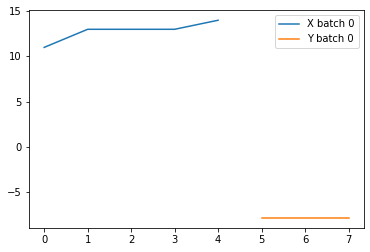

In [25]:
# Plot the evaluation predictions
import matplotlib.pyplot as plt

for idx,batch in enumerate(out_seq):
    plt.plot(torch.arange(0, history_x.size(1)), history_x[idx].cpu(), label=f"X batch {idx}")
    plt.plot(torch.arange(history_x.size(1),history_x.size(1)+batch.size(0)), batch.cpu(), label=f"Y batch {idx}")
plt.legend()